In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates
import math
import requests
import io
%matplotlib inline

from scipy.integrate import odeint
import lmfit

In [2]:
# Fetching Live Data from CSSE 
url_confirm="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
url_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
s_confirm = requests.get(url_confirm).content
s_death = requests.get(url_death).content
confirmed_df = pd.read_csv(io.StringIO(s_confirm.decode('utf-8')))
deaths_df = pd.read_csv(io.StringIO(s_death.decode('utf-8')))

In [3]:
confirmed_df.rename(columns={"Admin2": "County"}, inplace=True)
deaths_df.rename(columns={"Admin2": "County"}, inplace=True)

## Data from covidtracking.com

In [51]:
def get_state_data(state_): 
    url_state_covid_tracking ="https://covidtracking.com/api/v1/states/"+ state_ + "/daily.csv"
    state = requests.get(url_state_covid_tracking).content
    state_df = pd.read_csv(io.StringIO(state.decode('utf-8')))
    state_df["date"] = state_df["date"].apply(lambda x: datetime.strptime(str(x),"%Y%m%d"))
    checknan = state_df["positiveIncrease"].apply(lambda x: math.isnan(x))
    corrcoef = np.corrcoef(state_df[-checknan]["positiveIncrease"], state_df[-checknan]["totalTestResultsIncrease"])
    return state_df, corrcoef

In [54]:
newyork_df = get_state_data("NY")[0]
california_df = get_state_data("CA")[0]
georgia_df = get_state_data("GA")[0]

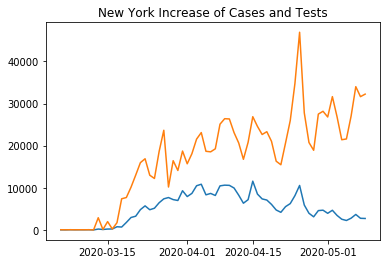

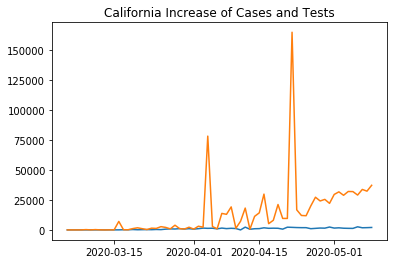

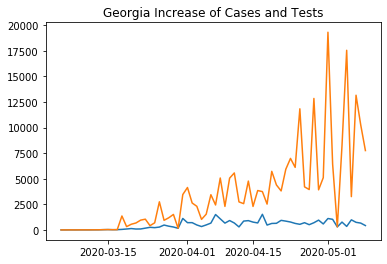

In [70]:
# New York 
states = {"New York": newyork_df, "California": california_df, "Georgia" : georgia_df}
for i in states.items(): 
    plt.title(i[0] + " Increase of Cases and Tests")
    plt.plot(i[1]["date"], np.array([i[1]["positiveIncrease"], i[1]["totalTestResultsIncrease"]]).T)
    plt.show()

Test results increase has a 0.68 positive correlation to the increase in positive tests. 

## Data Preprocessing

Data from: https://www.ahd.com/state_statistics.html

Data are based on each hospital's most recent Medicare cost report

In [10]:
hospital_data = pd.read_csv("hospitaldata_bystate.csv")
hospital_data["Number of Beds"] = hospital_data["Number of Beds"].apply(lambda x: int(x.replace(",","")))

Data from https://www.kff.org/other/state-indicator/distribution-by-age/

Notes: 2018 Data

"Population and demographic data on are based on analysis of the Census Bureau’s American Community Survey (ACS) and may differ from other population estimates published yearly by the Census Bureau. U.S. and state population data displayed on this site are restricted to the civilian, non-institutionalized population for whom ACS collects and reports poverty information.

Population numbers are rounded to the nearest 100."

In [11]:
agegroups = pd.read_csv("agedata_bystate.csv")

In [12]:
# read the data
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")

# create dicts for fast lookup
# 1. beds per state
beds_states_lookup = dict(zip(hospital_data["States"], hospital_data["Number of Beds"]))
# 2. agegroups per state
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['Children 0-18', 'Adults 19-25', 'Adults 26-34', 'Adults 35-54', 'Adults 55-64', '65+', 'Total']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

## Plotting Functions

In [13]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

## Create Model

In [14]:
# Rates are derived from literature review of COVID rates
# Number of days from infected to critical: 12 (→rate: 1/12)
# Number of days from critical to dead: 7.5 (→rate: 1/7.5)
# Number of days from critical to recovered: 6.5 (→rate: 1/6.5)
days_to_critical = 12.0
days_C_to_D = 7.5
days_C_to_R = 6.5

def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    '''
    Models the derivatives of the SEIR Model directly from epidemiological model
    '''
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/days_to_critical * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/days_to_critical * p_I_to_C * I - 1/days_C_to_D * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/days_C_to_R * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/days_C_to_R * min(Beds(t), C)
    dDdt = 1/days_C_to_D * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [15]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    '''
    Models the R_0 as a variable that changes over time
    t = time
    R_0_start = R_0 at the start of the model
    R_0_end = R_0 at the end of specified prediction time
    k = expresses the speed at which R_0 evolves
    x0 = inflection point for the change of R_0
    '''
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end


def Model(days, agegroups, beds_0, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    '''
    Function: takes the inputs and outputs the SEIRCD numbers for the population modeled by
    the derivative functions that we set before.
    
    ~ Input Variables ~ 
    
    days = number of days in our data
    agegroups = demographic breakdown of population in each agegroup in the region
    beds_0 = number of hospital beds in the state 
    R_0_start = R_0 at the start of our model
    k = how quickly R_0_start transitions to R_0_end, the speed of R_0 evolution 
    x0 = inflection point in the R_0
    R_0_end = R_0 at the end of our model
    prob_I_to_C = probability of infected patients becoming critical
    prob_C_to_D = probability of critical patients dying
    s = scale at which beds become available over time
    
    ~ Output Variables ~
    
    t = time
    S = population that is susceptible
    E = population that is exposed
    I = population that is infected
    C = population that is critical
    R = population that is recovered (removed from pool of susceptible)
    D = population that has died from the disease
    R_0_over_time = returns the R_0 over time in the model
    Beds = returns the number of beds available at each time step
    prob_I_to_C = probability of infected patients becoming critical
    prob_C_to_D = probability of critical patients dying
    '''
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        return beds_0*.1 + s*.1*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

## Simulated SEIR Model

percentage going to ICU: 5.0; percentage dying in ICU: 30.0


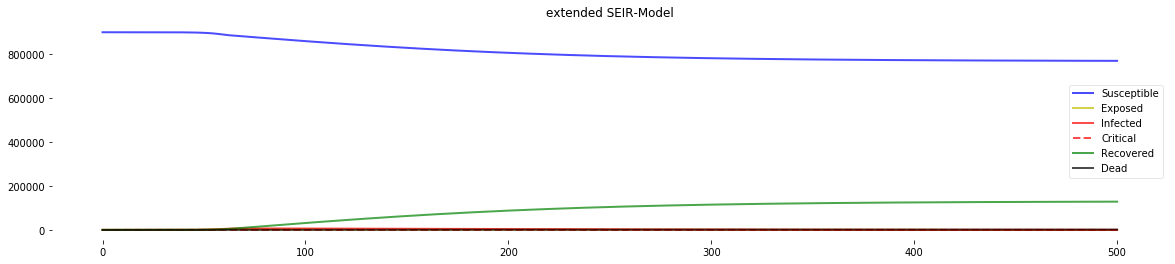

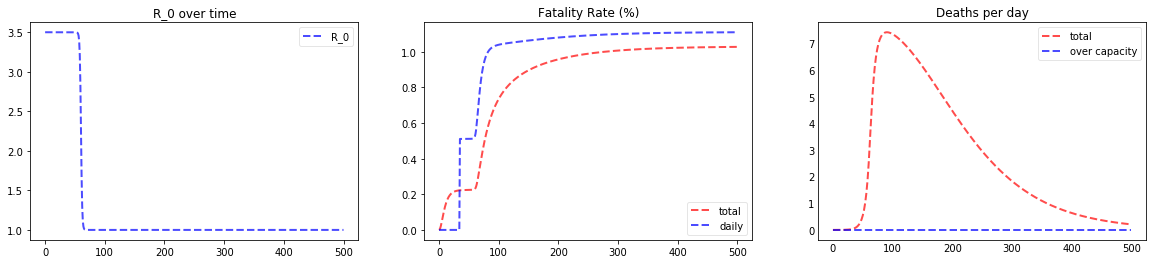

In [16]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_0 = 5000, R_0_start=3.5, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.3, s=0.003))

## Fit SEIR Model to our Data

### Preprocessing

In [17]:
# Deaths numbers starts at column index 12
deaths_df.iloc[:,[12]].head()

,1/22/20
0,0
1,0
2,0
3,0
4,0


In [18]:
deaths_by_state = pd.concat([deaths_df["Province_State"],deaths_df.iloc[:,12::]], axis=1)
deaths_by_state = deaths_by_state.groupby("Province_State").sum()

In [19]:
# Confirmed numbers
confirmed_by_state = pd.concat([confirmed_df["Province_State"],confirmed_df.iloc[:,11::]], axis=1)
confirmed_by_state = confirmed_by_state.groupby("Province_State").sum()

In [20]:
confirmed_by_state.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20
Province_State,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0,0,...,6912,7088,7294,7611,7888,8112,8437,8691,9046,9385
Alaska,0,0,0,0,0,0,0,0,0,0,...,355,355,364,365,368,370,371,372,374,377
American Samoa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arizona,0,0,0,0,1,1,1,1,1,1,...,7209,7655,7969,8364,8640,8924,9305,9707,9945,10526
Arkansas,0,0,0,0,0,0,0,0,0,0,...,3193,3281,3337,3372,3437,3491,3525,3611,3703,3747


### Specify Data for Modeling

In [71]:
def data_by_state(state_, outbreak_shift = 22): 
    '''
    ~ Modify for each state that we look at ~
    data = Deaths by state 
    data2 = Confirmed cases by state
    beds_in_-- = the number of beds in a specific state, modify lookup accordingly
    agegroups = the demographic breakdown in a specific state, modify lookup accordingly
    outbreakshift = number of days that we shift the outbreak back by to account for potential data inaccuracy
    params_init_min_max = initialize the epidemiological parameters for the SEIR model
    '''
    data = deaths_by_state[deaths_by_state.index == state_].values
    data = data[0]

    data2 = confirmed_by_state[confirmed_by_state.index == state_].values
    data2 = data2[0]

    agegroups = agegroup_lookup[state_]
    beds_in_state = beds_states_lookup[state_]
#     outbreak_shift = 22

    # form: {parameter: (initial guess, minimum value, max value)}
    params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (0.3, 0.01, 0.5), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                           "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                           "s": (0.003, 0.001, 0.01)}

    # Process Data for modeling
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    return data, data2, agegroups, beds_in_state, params_init_min_max, days, y_data, x_data

## Minimizing Residuals from Multiple Fits

In [88]:
from functools import partial

def residual(p, x, y_data, y_data_2):
    age_groups_error = var(agegroups, 100)
    beds_in_NY_error = var(np.array([beds_in_NY]),100)
    ret = Model(days, age_groups_error, beds_in_NY_error, **p)
    resid1 = y_data - ret[6][x]
    resid2 = y_data_2 - ret[3][x]
    return abs(resid1) + abs(resid2)

## Add error term 
def var(data,std):
    error = np.random.normal(0, scale = std)
    new_data = data + error
    new_data[new_data<0] = 0 
    return new_data

In [89]:
## Track parameter value 

def param_estimates_state(s_data, outbreak_shift = 22, sd = 20):
    param_estimate = []

    if outbreak_shift >= 0:
        y_data_2 = np.concatenate((np.zeros(outbreak_shift), s_data[1]))
    else:
        y_data_2 = y_data_2[-outbreak_shift:]

    pars = lmfit.Parameters()

    for kwarg, (init, mini, maxi) in s_data[4].items():
        pars.add(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    for i in range(5):
        y_data_error = var(s_data[6], sd)
        y_data_2_error = var(y_data_2, sd)
        function = partial(residual,x = s_data[7], y_data= y_data_error, y_data_2= y_data_2_error)
        mini = lmfit.Minimizer(function, pars)
        result = mini.minimize()
        temp = []
        for i,j in result.params.items():
            values = j.value
            temp.append(values)
        param_estimate.append(temp)
        
    return param_estimate, result

In [90]:
ny_data = data_by_state("New York", outbreak_shift = outbreak_shift)
ca_data = data_by_state("California", outbreak_shift = outbreak_shift)
ga_data = data_by_state("Georgia", outbreak_shift = outbreak_shift)

ny_params = param_estimates_state(ny_data)
ca_params = param_estimates_state(ca_data)
ga_params = param_estimates_state(ga_data)

In [93]:
# New York
pd.DataFrame(ny_params[0], columns = ny_params[1].params.keys())

,R_0_start,k,x0,R_0_end,prob_I_to_C,prob_C_to_D,s
0,3.000000,0.300000,90.000000,0.900000,0.050000,0.500000,0.003000
1,2.974331,0.301356,99.198864,1.050217,0.050140,0.499731,0.002973
2,2.375474,0.463893,99.058347,3.457028,0.028134,0.798833,0.009620
3,2.988463,0.298730,97.119113,0.989088,0.050227,0.496382,0.002933
4,2.954837,0.300617,91.108208,1.035712,0.052149,0.502271,0.003091


In [94]:
# California 
pd.DataFrame(ca_params[0], columns = ca_params[1].params.keys())

,R_0_start,k,x0,R_0_end,prob_I_to_C,prob_C_to_D,s
0,2.549119,0.349369,88.896532,1.168778,0.080967,0.055080,0.003082
1,2.558179,0.236301,96.181781,1.570029,0.099293,0.575452,0.001044
2,2.544827,0.356245,90.160932,1.008086,0.023631,0.224008,0.004814
3,2.628120,0.460211,93.273134,1.145808,0.083675,0.689823,0.003062
4,2.811078,0.346574,90.282876,0.927122,0.070889,0.087752,0.006675


In [95]:
# Georgia 
pd.DataFrame(ga_params[0], columns = ga_params[1].params.keys())

,R_0_start,k,x0,R_0_end,prob_I_to_C,prob_C_to_D,s
0,2.423516,0.297347,103.627272,1.465802,0.010452,0.534363,0.003299
1,2.421078,0.495388,101.007152,1.446683,0.071171,0.754040,0.008734
2,2.449576,0.388793,102.409877,1.168782,0.099550,0.799885,0.003108
3,2.421139,0.378896,101.991404,1.512911,0.071403,0.347790,0.008485
4,2.285869,0.361431,93.827869,2.134561,0.059314,0.371650,0.001103


### Results from Residual Fitting

In [105]:
def SEIR_by_state(state_name, state_df, outbreak_shift = 22, full_days = 500):
    first_date = np.datetime64(state_df.date.min()) - np.timedelta64(outbreak_shift,'D')
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    print("Prediction for " + state_name)
    fit_model = Model(full_days, agegroup_lookup[state_name], beds_states_lookup[state_name], **result.params)
    plt.plot(fit_model[3])
    plotter(*fit_model, x_ticks=x_ticks);

Prediction for New York
percentage going to ICU: 8.003615485936448; percentage dying in ICU: 77.73892535485722


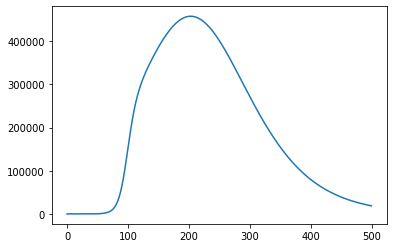

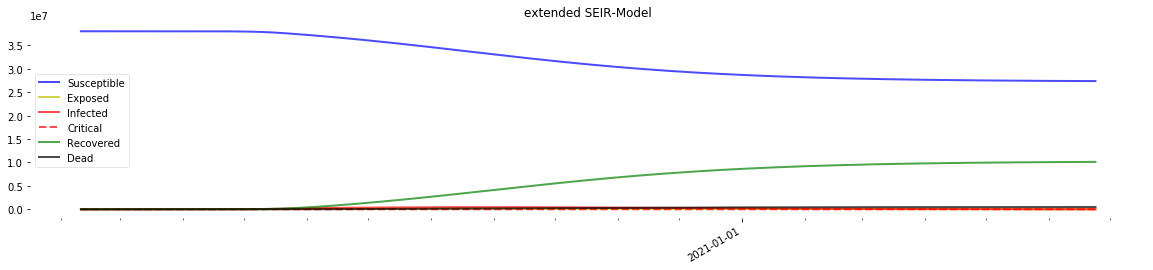

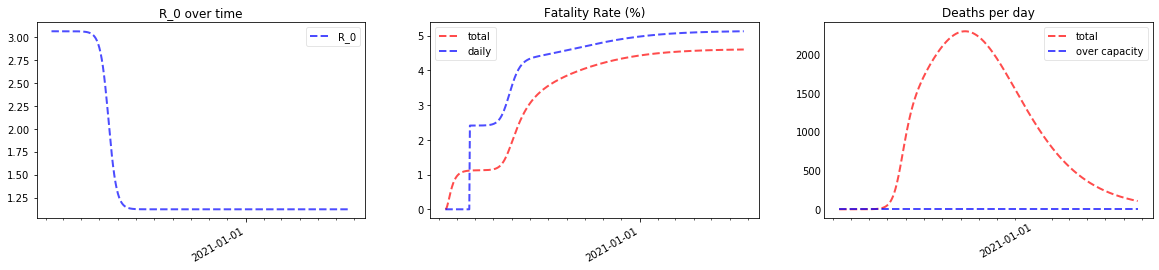

In [106]:
SEIR_by_state("New York", newyork_df)

Prediction for California
percentage going to ICU: 8.003615485936448; percentage dying in ICU: 77.73892535485722


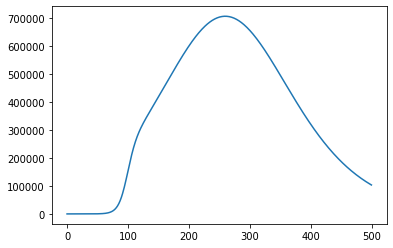

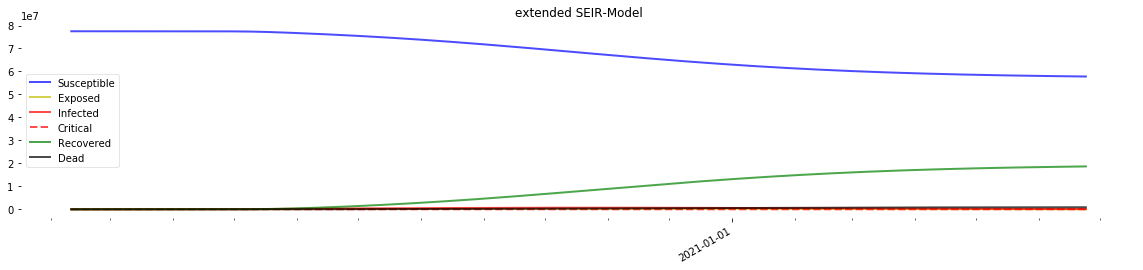

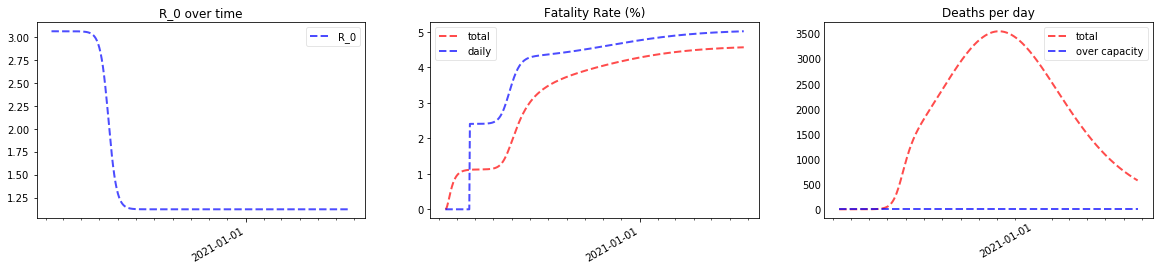

In [107]:
SEIR_by_state("California", california_df)

Prediction for Georgia
percentage going to ICU: 8.003615485936448; percentage dying in ICU: 77.73892535485722


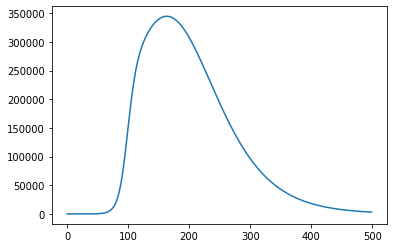

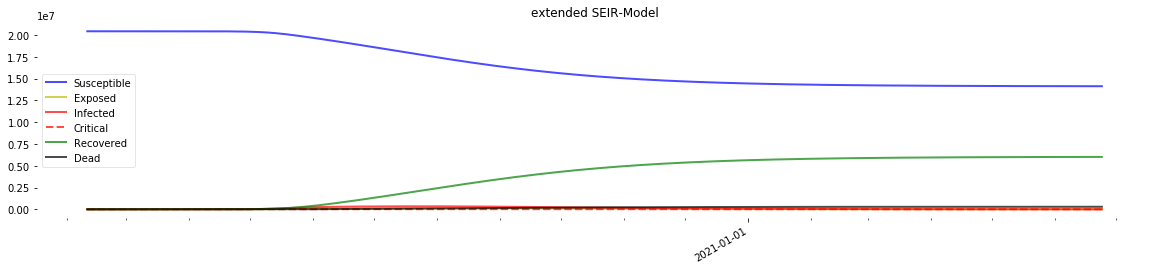

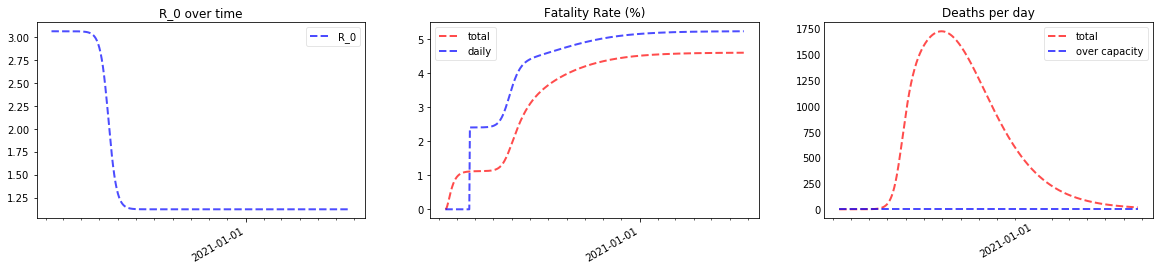

In [108]:
SEIR_by_state("Georgia", georgia_df)

## Regular Fitting to Line

In [112]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_in_NY, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [115]:
def model_fit(state_data):
    mod= lmfit.Model(fitter)
#   iterate through initial parameters for each state
    for kwarg, (init, mini, maxi) in state_data[4].items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()
    fit_method = "least_squares"
    result = mod.fit(state_data[6], params, method=fit_method, x=state_data[7])
    return result

In [116]:
ny_model = model_fit(ny_data)
ca_model = model_fit(ca_data)
ga_model = model_fit(ga_data)

{'R_0_start': 4.138888654393021,
 'k': 0.49999999999994577,
 'x0': 91.8850036412254,
 'R_0_end': 0.300000159387523,
 'prob_I_to_C': 0.025414457912267145,
 'prob_C_to_D': 0.09269051374974271,
 's': 0.003}

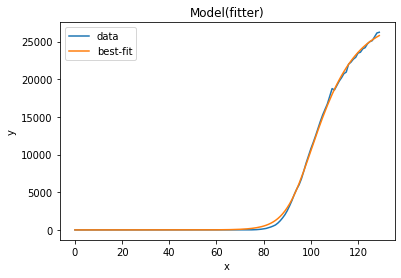

In [126]:
# New York
ny_model.plot_fit(datafmt="-")
ny_model.best_values

{'R_0_start': 3.7824523889305057,
 'k': 0.14416523389858912,
 'x0': 92.12654032163329,
 'R_0_end': 0.8773100974232132,
 'prob_I_to_C': 0.010000001917496018,
 'prob_C_to_D': 0.050000005683787235,
 's': 0.003}

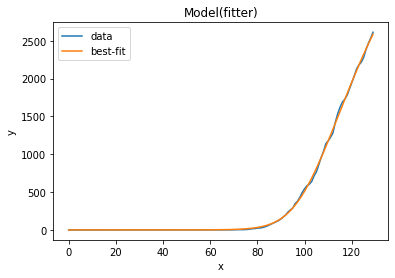

In [127]:
# California
ca_model.plot_fit(datafmt="-")
ca_model.best_values

{'R_0_start': 3.632734900822009,
 'k': 0.4999569023193308,
 'x0': 89.65910179119652,
 'R_0_end': 1.018236956612122,
 'prob_I_to_C': 0.010000114205821418,
 'prob_C_to_D': 0.05000015444186815,
 's': 0.003}

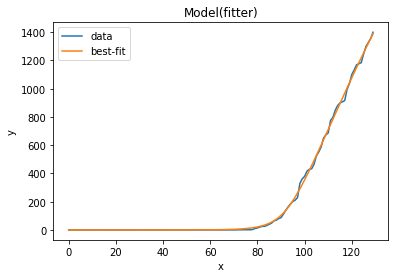

In [128]:
# Georgia
ga_model.plot_fit(datafmt="-")
ga_model.best_values